In [1]:
import pymongo                            # Library to access MongoDB
from pymongo import MongoClient           # Imports MongoClient 
import pandas as pd                       # Library to work with dataframes
import folium                             # Library to create the map
from folium import plugins                # plugin to create a heatmap
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import re

In [2]:
# uri (uniform resource identifier) defines the connection parameters 
uri = 'mongodb://127.0.0.1:27017'
# start client to connect to MongoDB server 
client = MongoClient( uri )
db = client.JiraRepos

# Functions

In [3]:
def lexicon_to_array():
    lexicon = pd.read_csv('Harassment Lexicon.csv')
    arr = lexicon.fillna('').astype(str).values.flatten().tolist()
    # Ditch some words here with special characters.
    return [i for i in arr if i and not re.search("[()*!?]", i)]

def lexicon_to_space_delimited():
    return " ".join(lexicon_to_array())

In [22]:
cursor = db.SecondLife.aggregate([
    { "$match": { "fields.comments": { "$exists": True, "$ne": [] }}},
    { "$replaceWith": { "comments": "$fields.comments" }},
    { "$unwind": { "path": "$comments" }},
    { "$replaceRoot": { "newRoot": "$comments" }},
    { "$group": {
        "_id": "$author.key",
        "firstCommentDate": {
            "$min": { "$dateFromString": { "dateString": "$created" } }
        },
        "lastCommentDate": {
            "$max": { "$dateFromString": { "dateString": "$created" } }
        },
        "numComments": { "$count": {} },
        "numToxicComments": {
            "$sum": {
                "$toInt": {
                    "$regexMatch": {
                        "input": "$body",
                        "regex": "/" + "|".join(lexicon_to_array()) + "/",
                        "options": "i"
                    }
                }
            }
        }
#        "comments": { "$addToSet": "$body" }
    }},
    { "$addFields": {
        "activeness": {
            "$divide": [
                { "$subtract": ["$lastCommentDate", "$firstCommentDate"] },
                "$numComments"
            ]
        },
        "toxicity": {
           "$divide": ["$numToxicComments", "$numComments"]
        }
    }}
])

df = pd.DataFrame(list(cursor))
df.head()

,_id,firstCommentDate,lastCommentDate,numComments,numToxicComments,activeness,toxicity
0,gez.linden,2009-12-22 00:09:41.000,2009-12-22 00:09:41.000,1,0,0.000000e+00,0.000000
1,super1,2011-03-04 05:44:49.434,2011-03-04 05:44:49.434,1,0,0.000000e+00,0.000000
2,chorazin.allen,2019-03-01 15:40:20.658,2019-03-04 15:09:03.570,4,3,6.433073e+07,0.750000
3,leal.choche,2010-12-27 19:09:13.786,2010-12-27 19:09:13.786,1,0,0.000000e+00,0.000000
4,ansariel.hiller,2011-03-15 21:57:27.971,2018-06-19 19:48:10.956,93,53,2.464639e+09,0.569892


<AxesSubplot:xlabel='activeness', ylabel='toxicity'>

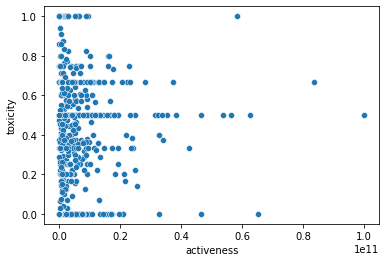

In [23]:
sns.scatterplot(data=df, x="activeness", y="toxicity")